In [1]:
# Data Processing Libraries
import pandas as pd
import os
import csv
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

# Model Libraries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import regularizers

2023-12-06 22:47:56.656604: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load Model Data 
Checkpoint: Load cached data here

In [2]:
# Test Loading Data
model_data_df = pickle.load(open('data/model_data.pkl', 'rb'))
model_data_df

,race,sample_data,label
0,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Metaplastic carcinoma, NOS"
1,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Metaplastic carcinoma, NOS"
2,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
3,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
4,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
...,...,...,...
1495,not reported,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1496,not reported,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1497,black or african american,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1498,black or african american,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"


### Preprocess Data

In [3]:
# ONE HOT ENCODE DATA
encoded_labels = pd.get_dummies(model_data_df.label)
encoded_df = model_data_df.join(encoded_labels)


In [4]:
# Filter Data Frames
white_df = encoded_df[encoded_df["race"] == "white"]
black_df = encoded_df[encoded_df["race"] == "black or african american"]

prognosis_names = encoded_df.label.unique()



### Model Results for (train white, test black)

In [ ]:
# Get (x, y)
def get_x_y(df, prognosis_names): 
    x = np.stack(df.sample_data.values)
    y = df.filter(prognosis_names).values
    return x, y

def split_in_half(data):
    x, y = data
    x_val, x_test, y_val, y_test = train_test_split(x, y, test_size=0.5, random_state=42)
    return x_val, x_test, y_val, y_test 

##### Main Code #########
x_w, y_w = get_x_y(white_df, prognosis_names) # training data
x_val, x_test, y_val, y_test = split_in_half(get_x_y(black_df, prognosis_names))

In [31]:
# TRAIN NEURAL NETWORK
num_classes = model_data_df.label.nunique()

# Basic DNN Model 
reg_rate = 0.1
model = Sequential([
    Flatten(input_shape=(60623, 26)),  # Flattening the input
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(reg_rate)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(reg_rate)),
    Dense(num_classes, activation='softmax')  # Output layer with softmax for multi-class
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_w, y_w, epochs=40, batch_size=32, validation_data=(x_val, y_val))


Epoch 1/40
32/32 [==============================] - 51s 2s/step - loss: 97.3049 - accuracy: 0.4936 - val_loss: 41.3150 - val_accuracy: 0.8047
Epoch 2/40
32/32 [==============================] - 51s 2s/step - loss: 35.1965 - accuracy: 0.5222 - val_loss: 23.5241 - val_accuracy: 0.1719
Epoch 3/40
32/32 [==============================] - 47s 1s/step - loss: 16.0770 - accuracy: 0.6061 - val_loss: 10.7216 - val_accuracy: 0.5234
Epoch 4/40
32/32 [==============================] - 47s 1s/step - loss: 8.8680 - accuracy: 0.5597 - val_loss: 10.9343 - val_accuracy: 0.7031
Epoch 5/40
32/32 [==============================] - 51s 2s/step - loss: 9.9642 - accuracy: 0.5538 - val_loss: 6.5611 - val_accuracy: 0.5938
Epoch 6/40
32/32 [==============================] - 48s 1s/step - loss: 5.5311 - accuracy: 0.6061 - val_loss: 5.4341 - val_accuracy: 0.5703
Epoch 7/40
32/32 [==============================] - 48s 1s/step - loss: 4.3384 - accuracy: 0.6881 - val_loss: 4.4304 - val_accuracy: 0.8047
Epoch 8/40
32

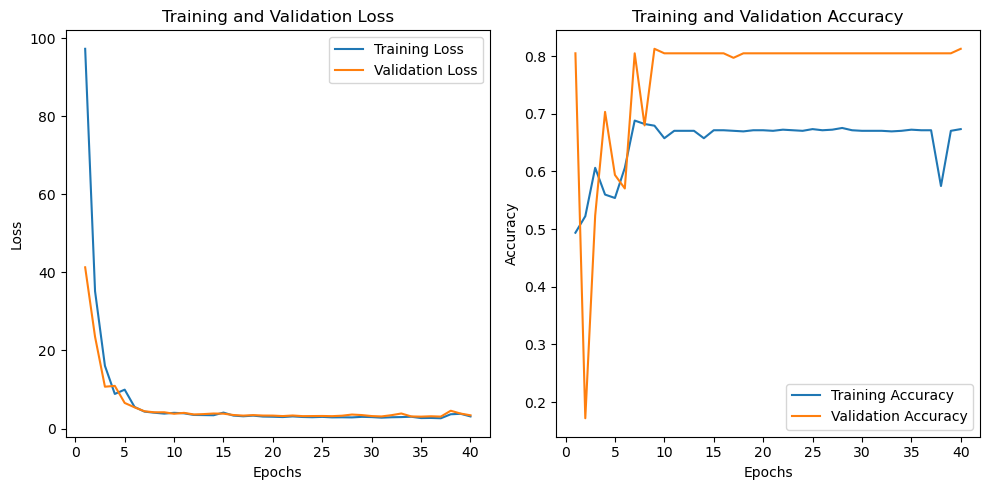

In [32]:
# PLOT MODEL PROGRESS

# Get training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
# Check Test Performance 
evaluation = model.evaluate(x_test, y_test)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


5/5 [==============================] - 1s 75ms/step - loss: 3.4009 - accuracy: 0.8062
Loss on test data: 3.4008708000183105
Accuracy on test data: 0.8062015771865845


### Model Results for (train black, test black)

In [5]:
# Get (x, y)
def get_x_y(df, prognosis_names): 
    x = np.stack(df.sample_data.values)
    y = df.filter(prognosis_names).values
    return x, y

def test_split(data):
    x, y = data
    x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(x, y, test_size=0.7, random_state=42)
    return x_train, x_val_and_test, y_train, y_val_and_test 


##### Main Code #########
x_train, x_val_and_test, y_train, y_val_and_test  = test_split(get_x_y(black_df, prognosis_names))
x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size=0.5, random_state=42)

In [6]:
# TRAIN NEURAL NETWORK
num_classes = model_data_df.label.nunique()

# Basic DNN Model 
reg_rate = 0.1
model = Sequential([
    Flatten(input_shape=(60623, 26)),  # Flattening the input
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(reg_rate)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(reg_rate)),
    Dense(num_classes, activation='softmax')  # Output layer with softmax for multi-class
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=40, batch_size=32, validation_data=(x_val, y_val))


Epoch 1/40
3/3 [==============================] - 11s 3s/step - loss: 63.2410 - accuracy: 0.4026 - val_loss: 64.6380 - val_accuracy: 0.0000e+00
Epoch 2/40
3/3 [==============================] - 5s 2s/step - loss: 86.9005 - accuracy: 0.4286 - val_loss: 122.7439 - val_accuracy: 0.7889
Epoch 3/40
3/3 [==============================] - 5s 2s/step - loss: 110.2773 - accuracy: 0.7792 - val_loss: 81.3900 - val_accuracy: 0.7889
Epoch 4/40
3/3 [==============================] - 4s 2s/step - loss: 78.1960 - accuracy: 0.6623 - val_loss: 156.3161 - val_accuracy: 0.0000e+00
Epoch 5/40
3/3 [==============================] - 4s 1s/step - loss: 91.4700 - accuracy: 0.4805 - val_loss: 86.0915 - val_accuracy: 0.7889
Epoch 6/40
3/3 [==============================] - 4s 1s/step - loss: 75.6653 - accuracy: 0.7792 - val_loss: 80.2447 - val_accuracy: 0.7889
Epoch 7/40
3/3 [==============================] - 4s 1s/step - loss: 62.0194 - accuracy: 0.6623 - val_loss: 75.4849 - val_accuracy: 0.1222
Epoch 8/40
3/3 

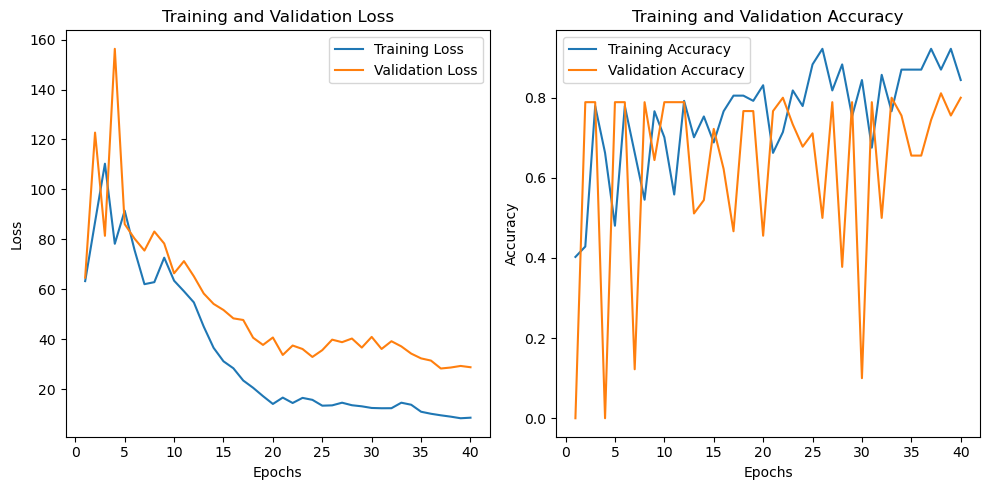

In [7]:
# PLOT MODEL PROGRESS

# Get training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# Check Test Performance 
evaluation = model.evaluate(x_test, y_test)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


3/3 [==============================] - 0s 90ms/step - loss: 17.8460 - accuracy: 0.8333
Loss on test data: 17.846046447753906
Accuracy on test data: 0.8333333134651184
